# Notebook for generating folds
1. First cell -> create folds from dataset
2. Second cell -> visualize sample images with bounding boxes

In [1]:
import sklearn
from sklearn.model_selection import KFold
from pathlib import Path
import yaml
import shutil
import random

# Percorso del dataset (radice che contiene train/, test/)
DATASET_DIR = Path("roboflow_augmented")
OUTPUT_DIR = Path("k_fold_cv_augmented")

# load the train set of the dataset
train_set_path = DATASET_DIR / "train" / "images"
if not train_set_path.exists():
    raise FileNotFoundError(f"Train set path {train_set_path} does not exist.")

# load the data.yaml file
data_yaml_path = DATASET_DIR / "data.yaml"
if not data_yaml_path.exists():
    raise FileNotFoundError(f"Data YAML file {data_yaml_path} does not exist.")
with open(data_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# create a parametric cross validation splitter
from sklearn.model_selection import KFold
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
# create the output directory if it does not exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)   
# iterate over the folds

# Get the list of image files once, sorted for reproducibility
image_files = sorted(list(train_set_path.glob("*.jpg")))

for fold, (train_index, val_index) in enumerate(kf.split(image_files)):
    print(f"Processing fold {fold + 1}/{k_folds}")
    fold_dir = OUTPUT_DIR / f"fold_{fold}"
    fold_dir.mkdir(parents=True, exist_ok=True)

    # Create train/val images and labels directories
    train_images_dir = fold_dir / "train" / "images"
    train_labels_dir = fold_dir / "train" / "labels"
    val_images_dir = fold_dir / "val" / "images"
    val_labels_dir = fold_dir / "val" / "labels"
    train_images_dir.mkdir(parents=True, exist_ok=True)
    train_labels_dir.mkdir(parents=True, exist_ok=True)
    val_images_dir.mkdir(parents=True, exist_ok=True)
    val_labels_dir.mkdir(parents=True, exist_ok=True)

    # Copy images
    for idx in train_index:
        src = image_files[idx]
        shutil.copy(src, train_images_dir / src.name)
    for idx in val_index:
        src = image_files[idx]
        shutil.copy(src, val_images_dir / src.name)

    fold_labels_dir = DATASET_DIR / "train" / "labels"

    # Copy labels
    for idx in train_index:
        label_file = fold_labels_dir / f"{image_files[idx].stem}.txt"
        if label_file.exists():
            shutil.copy(label_file, train_labels_dir / label_file.name)
    for idx in val_index:
        label_file = fold_labels_dir / f"{image_files[idx].stem}.txt"
        if label_file.exists():
            shutil.copy(label_file, val_labels_dir / label_file.name)

    # Update data.yaml for the current fold
    data_yaml['train'] = str((fold_dir / "train" / "images").relative_to(OUTPUT_DIR))
    data_yaml['val'] = str((fold_dir / "val" / "images").relative_to(OUTPUT_DIR))

    with open(fold_dir / "data.yaml", 'w') as file:
        yaml.dump(data_yaml, file)



Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5


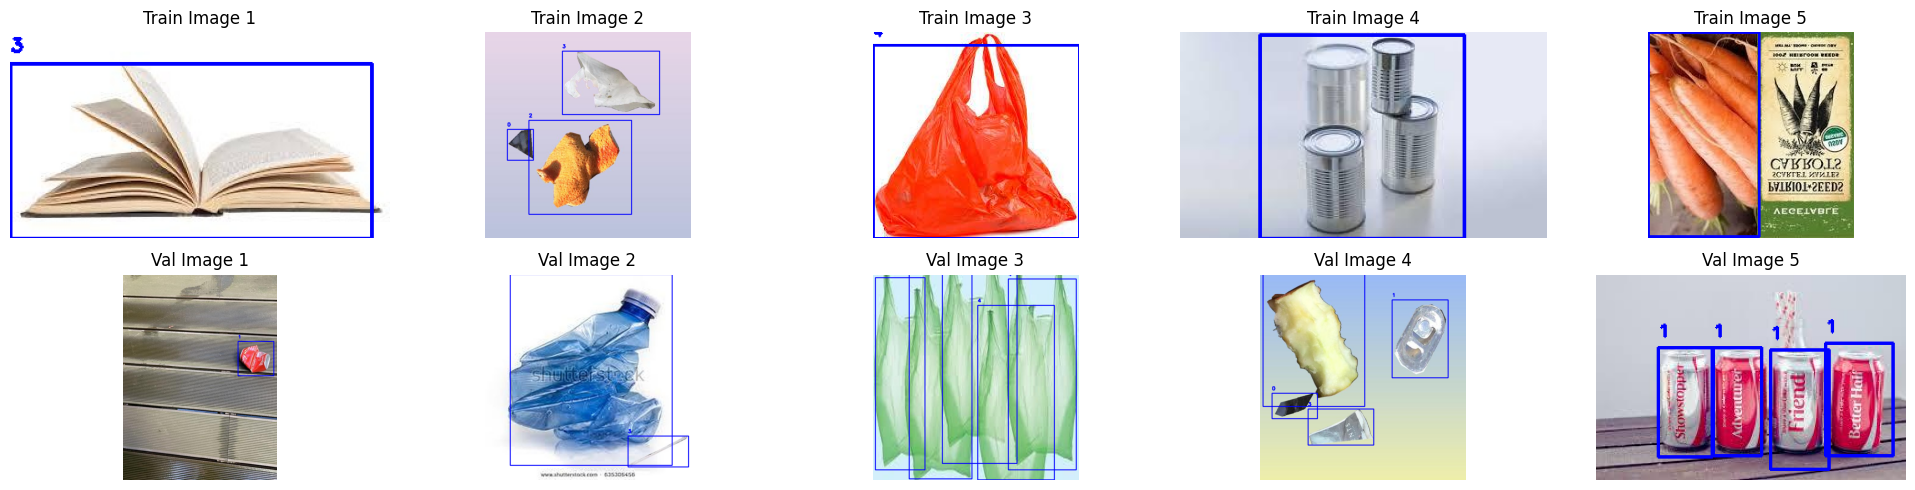

In [6]:
import matplotlib.pyplot as plt
import cv2
import random

def plot_fold_examples(fold_dir, num_examples=5):
    train_images_dir = fold_dir / "train" / "images"
    val_images_dir = fold_dir / "val" / "images"
    train_labels_dir = fold_dir / "train" / "labels"
    val_labels_dir = fold_dir / "val" / "labels"
    
    train_images = sorted(train_images_dir.glob("*.jpg"))
    val_images = sorted(val_images_dir.glob("*.jpg"))
    
    # Randomly sample images (without replacement)
    train_samples = random.sample(train_images, min(num_examples, len(train_images)))
    val_samples = random.sample(val_images, min(num_examples, len(val_images)))
    
    fig, axes = plt.subplots(2, num_examples, figsize=(20, 5))
    
    for i in range(num_examples):
        # Train images
        if i < len(train_samples):
            img = cv2.imread(str(train_samples[i]))
            label_file = train_labels_dir / f"{train_samples[i].stem}.txt"
            if label_file.exists():
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        class_id = int(float(parts[0]))
                        x_center, y_center, width, height = map(float, parts[1:])
                        img_height, img_width = img.shape[:2]
                        x1 = int((x_center - width / 2) * img_width)
                        y1 = int((y_center - height / 2) * img_height)
                        x2 = int((x_center + width / 2) * img_width)
                        y2 = int((y_center + height / 2) * img_height)
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            axes[0, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[0, i].set_title(f"Train Image {i+1}")
            axes[0, i].axis('off')
        else:
            axes[0, i].axis('off')
        
        # Val images
        if i < len(val_samples):
            img = cv2.imread(str(val_samples[i]))
            label_file = val_labels_dir / f"{val_samples[i].stem}.txt"
            if label_file.exists():
                with open(label_file, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        class_id = int(float(parts[0]))
                        x_center, y_center, width, height = map(float, parts[1:])
                        img_height, img_width = img.shape[:2]
                        x1 = int((x_center - width / 2) * img_width)
                        y1 = int((y_center - height / 2) * img_height)
                        x2 = int((x_center + width / 2) * img_width)
                        y2 = int((y_center + height / 2) * img_height)
                        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                        cv2.putText(img, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            axes[1, i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axes[1, i].set_title(f"Val Image {i+1}")
            axes[1, i].axis('off')
        else:
            axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot examples from the first fold
first_fold_dir = OUTPUT_DIR / "fold_0"
plot_fold_examples(first_fold_dir, num_examples=5)